In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os

In [ ]:
prj_dir = '/Users/kang-shinwon/dev/personal/sensor_fusion'
calibs_dir = prj_dir + '/sample_data/calibs'
lidar_dir = prj_dir + '/sample_data/points'
image_dir = prj_dir + '/sample_data/images'
label_dir = prj_dir + '/sample_data/labels'

In [ ]:
# load pcd data 
points = np.fromfile(lidar_dir + '/000031.pcd', dtype=np.float32).reshape((-1,4))
points = points[:, :3]

# load camera
# image = cv2.imread(image_dir + '/000031.png')
image = cv2.cvtColor(cv2.imread(os.path.join(image_dir + '/000031.png')), cv2.COLOR_BGR2RGB)
img_height, img_width, img_channel = image.shape

# load calibration data
calib_file = open(calibs_dir + '/000031.txt', 'r')
calib_lines = calib_file.readlines()

p0 = np.array(calib_lines[0].strip('\n').split(' ')[1:], dtype=np.float32).reshape(3, 4)
p1 = np.array(calib_lines[1].strip('\n').split(' ')[1:], dtype=np.float32).reshape(3, 4)
p2 = np.array(calib_lines[2].strip('\n').split(' ')[1:], dtype=np.float32).reshape(3, 4)
p3 = np.array(calib_lines[3].strip('\n').split(' ')[1:], dtype=np.float32).reshape(3, 4)

r0_rect = np.array(calib_lines[4].strip('\n').split(' ')[1:], dtype=np.float32).reshape(3, 3)
r0_rect = np.insert(r0_rect,3,values=[0,0,0],axis=0)
r0_rect = np.insert(r0_rect,3,values=[0,0,0,1],axis=1)

tr_velo_to_cam = np.array(calib_lines[5].strip('\n').split(' ')[1:], dtype=np.float32).reshape(3, 4)
tr_velo_to_cam = np.vstack((tr_velo_to_cam, np.array([0, 0, 0, 1], dtype=np.float32)))

tr_imu_to_velo = np.array(calib_lines[6].strip('\n').split(' ')[1:], dtype=np.float32).reshape(3, 4)

# load label
label_file = open(label_dir + '/000031.txt', 'r')

In [ ]:
r0_rect_t = np.array([float(x) for x in calib_lines[4].strip('\n').split(' ')[1:]]).reshape(3,3)
r0_rect_t = np.insert(r0_rect_t,3,values=[0,0,0],axis=0)
r0_rect_t = np.insert(r0_rect_t,3,values=[0,0,0,1],axis=1)
print(r0_rect_t)

In [ ]:
print('points: {}\n{}'.format(points.shape, points))
print('image: {}\n{}'.format(image.shape, image))

In [ ]:
def lidar2cam(p2, r0_rect, tr_velo_to_cam, points):
    points = np.vstack((points, np.ones((1, points.shape[1]))))
    print(points.shape)

    lidar_cam = p0 @ r0_rect @ tr_velo_to_cam @ points
    lidar_cam[:2, :] /= lidar_cam[2, :]
    return lidar_cam[:2, :]

def object_on_image():
    pass

def object_on_lidar():
    pass

def lidar2bev():
    pass

In [ ]:
lidar_cam = lidar2cam(p2, r0_rect, tr_velo_to_cam, points.T)

In [ ]:
lidar_cam

In [ ]:
print(points.shape, lidar_cam.shape)

In [ ]:
inds = np.where((lidar_cam[0, :] < img_width) & (lidar_cam[0, :] >= 0) &
                    (lidar_cam[1, :] < img_height) & (lidar_cam[1, :] >= 0) &
                    (points[:, 0] > 0)
                    )[0]

# Filter out pixels points
imgfov_pc_pixel = lidar_cam[:, inds]

# Retrieve depth from lidar
imgfov_pc_velo = points[inds, :]
imgfov_pc_velo = np.hstack((imgfov_pc_velo, np.ones((imgfov_pc_velo.shape[0], 1))))
imgfov_pc_cam2 = (p0 @ r0_rect @ tr_velo_to_cam) @ imgfov_pc_velo.transpose()

cmap = plt.cm.get_cmap('hsv', 256)
cmap = np.array([cmap(i) for i in range(256)])[:, :3] * 255

for i in range(imgfov_pc_pixel.shape[1]):
    depth = imgfov_pc_cam2[2, i]
    color = cmap[int(640.0 / depth), :]
    cv2.circle(image, (int(np.round(imgfov_pc_pixel[0, i])),
                        int(np.round(imgfov_pc_pixel[1, i]))),
                2, color=tuple(color), thickness=-1)
plt.imshow(image)

In [508]:
import sys

img = f'/Users/kang-shinwon/dev/personal/sensor_fusion/sample_data/images/000031.png'
binary = f'/Users/kang-shinwon/dev/personal/sensor_fusion/sample_data/points/000031.pcd'
with open(f'/Users/kang-shinwon/dev/personal/sensor_fusion/sample_data/calibs/000031.txt','r') as f:
    calib = f.readlines()

# P2 (3 x 4) for left eye
P2 = np.array([float(x) for x in calib[2].strip('\n').split(' ')[1:]]).reshape(3,4)
R0_rect = np.array([float(x) for x in calib[4].strip('\n').split(' ')[1:]]).reshape(3,3)
# Add a 1 in bottom-right, reshape to 4 x 4
R0_rect = np.insert(R0_rect,3,values=[0,0,0],axis=0)
R0_rect = np.insert(R0_rect,3,values=[0,0,0,1],axis=1)
Tr_velo_to_cam = np.array([float(x) for x in calib[5].strip('\n').split(' ')[1:]]).reshape(3,4)
Tr_velo_to_cam = np.insert(Tr_velo_to_cam,3,values=[0,0,0,1],axis=0)

# read raw data from binary
scan = np.fromfile(binary, dtype=np.float32).reshape((-1,4))
points = scan[:, 0:3] # lidar xyz (front, left, up)
# TODO: use fov filter? 
velo = np.insert(points,3,1,axis=1).T
velo = np.delete(velo,np.where(velo[0,:]<0),axis=1)
cam = P2.dot(R0_rect.dot(Tr_velo_to_cam.dot(velo)))
cam = np.delete(cam,np.where(cam[2,:]<0),axis=1)
# get u,v,z
cam[:2] /= cam[2,:]

In [509]:
print(cam)

[[-5.80082340e+06 -5.80082340e+06 -5.80082340e+06 ... -5.80082340e+06
   6.09728707e+02 -1.19719996e+02]
 [ 6.14704681e+04  6.14704680e+04  6.14704681e+04 ...  6.14704681e+04
   1.80394053e+02 -6.88573251e+04]
 [ 1.01065332e+29  3.77454619e+28  5.83196245e+23 ...  6.98095008e+15
   5.86045649e+35  1.99749191e+15]]


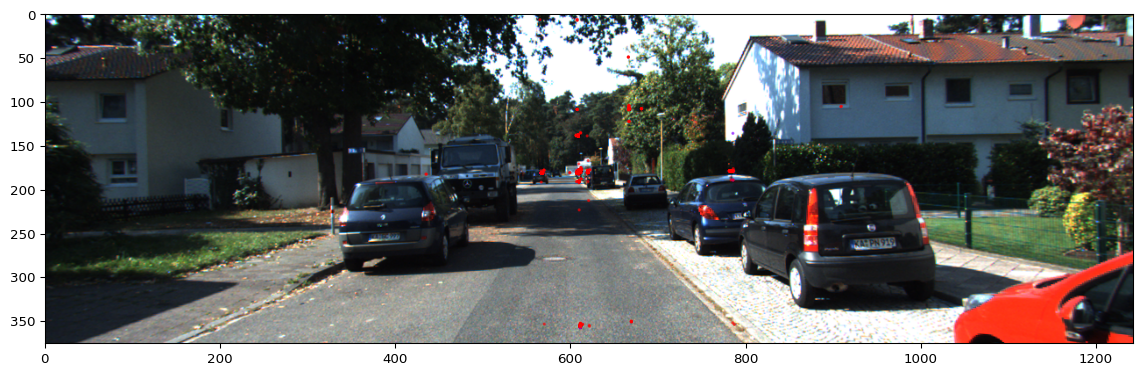

In [510]:
import matplotlib.image as mpimg

plt.figure(figsize=(12,5),dpi=96,tight_layout=True)
png = mpimg.imread(img)
IMG_H,IMG_W,_ = png.shape
# restrict canvas in range
plt.axis([0,IMG_W,IMG_H,0])
plt.imshow(png)
# filter point out of canvas
u,v,z = cam
u_out = np.logical_or(u<0, u>IMG_W)
v_out = np.logical_or(v<0, v>IMG_H)
outlier = np.logical_or(u_out, v_out)
cam = np.delete(cam,np.where(outlier),axis=1)
# generate color map from depth
u,v,z = cam
plt.scatter([u],[v],c=[z],cmap='rainbow_r',alpha=0.5,s=2)
# plt.title(name)
# plt.savefig(f'./data_object_image_2/testing/projection/{name}.png',bbox_inches='tight')
plt.show()